# Let's get the data!

Welcome to the inaugural blog post!

In this blog we'll cover how we imported the dataset into a python coding environment, and readied the dataframe for analysis and visualisation. 

Before starting, we've downloaded the bicycle volume and speed data located on the DataVic site here:
https://discover.data.vic.gov.au/dataset/bicycle-volume-and-speed

The data shows cycling flows in both directions recorded at 42 off-road counter sites and 4 on-road counter sites in Melbourne.

The dataset is delivered in a large number of CSV files, with each file containing several days worth of data from one seonsor location. There's also an excel file called 'VicRoads_Bike_Site_Number_Listing' which indexes the location of each of the sensors. 

While the files could be programmatically unzipped with code, we unzipped them all using 7-zip in one big batch. Easy!

In [2]:
# We'll be coding in Python using Jupyter notebook
# We'll start off by importing all the python libraries that we'll need in the one spot.

import pandas as pd
import numpy as np
import os
from collections import Counter
from tqdm.notebook import tqdm
import plotly.express as px
import geopandas as gpd
import plotly.graph_objects as go


In [3]:
# Let's create a couple of variables for the operating system file paths to access the CSVs downloaded from DataVic.
# This will save time later on! 

# We'll also limit our data to the last 5 years, from 2017 to 2021

rootdir = '../../data/DPC/bicycle_flows/'
visuals = '../docs/visuals/bicycle_flows/'

data_years = [2017,2018,2019,2020,2021]
folder_prefix = 'Bicycle_Volume_Speed_'

## Data validation 

There's a lot of CSVs, so lets first make sure that each CSV has the same variables or columns.

Once this is confirmed, we'll be able to combine all of the individual CSVs into a dataframe.



In [208]:
# This code iterates over each of the CSVs and tallies the number of unique column combinations. 

# Ideally, the result will be a single combination of columns, so we'll be able to append each to a
# new dataframe. Let's see!




for year in data_years:
    tally = pd.DataFrame(columns=["count","len"])
    counter = 0
    for subdir, dirs, files in tqdm(os.walk(rootdir)):
        for file in files:
            if ('.csv' in file) and ('.zip' not in file):
            # read in CSV, if it contains records (which at least one doesn't!)
                file_path = os.path.join(subdir,file) 
                if os.path.getsize(file_path) > 0:
                    df = pd.read_csv(os.path.join(subdir,file))
                # store list of columns in variable df_columns as a string
                    df_columns = f"{df.columns.to_list()}"
                    # if CSV columns string is in the tally index, increment this
                    if df_columns in tally.index:
                        tally[tally.index==df_columns] += 1
                        # otherwise add CSV columns string to the tally index
                    else:
                        tally.loc[df_columns] = 1
                        # increment a counter; athough theoretically this should only sum to the sum of tallies!
                        counter+=1

print(counter)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

1


In [209]:
# Great, only 1 unique combo!

# Let's check out that combination of variables.

tally

,count,len
"['DATA_TYPE', 'TIS_DATA_REQUEST', 'SITE_XN_ROUTE', 'LOC_LEG', 'DATE', 'TIME', 'CLASS', 'LANE', 'SPEED', 'WHEELBASE', 'HEADWAY', 'GAP', 'AXLE', 'AXLE_GROUPING', 'RHO', 'VEHICLE', 'DIRECTION']",16054,16054


## Creating a dataframe

Now that we know that all of the CSVs share the same column names, we'll join the various files together to create a dataframe to run the analysis. 

In [90]:
# We'll start by creating an empty dataframe list to put the data into, and then we'll 'go for a walk' through the operating system
# to pick up the files we want. We'll make sure we're only collecting CSVs & files that have data (ie, are larger than 0)

# TQDM is a wrapper which creates a processing progress bar - useful when there's a lot of files!

filename = 'combined_bicycle_summary'
analysis_period = 'W'

if os.path.exists(os.path.abspath(f'{filename}_{analysis_period}.csv')):
    df = pd.read_csv(os.path.abspath(f'{filename}_{analysis_period}.csv'), parse_dates = True)
else:
    df = {}
    for year in tqdm(data_years, unit = 'years'):
        csv_files = []
        for subdir, dirs, files in tqdm(os.walk(f'{rootdir}/{folder_prefix}{year}'),
                                        desc= f"Getting CSV file paths ({year})...",
                                        unit="CSVs",
                                        leave = False):
            for file in files:
                if ('.csv' in file) and ('.zip' not in file):
                    # record filepaths of CSVs containing records
                    file_path = os.path.join(subdir,file)
                    # let's make sure we only join files that contain data
                    if os.path.getsize(file_path) > 0:
                        csv_files.append(os.path.join(subdir,file))
        dfs=[]
        for csv in tqdm(csv_files,desc=f"Reading csv files for {year}...",unit="CSVs", leave = False):
            dfs.append(pd.read_csv(csv, index_col=None, header=0))
        # Here we'll create a new variable called 'month_year'. 
        # This will allow us to aggregate the daily data, which will hopefully cut down on the processing needed.
        dfs = pd.concat(dfs, axis=0, ignore_index=True)
        dfs['year_M'] = pd.to_datetime(dfs['DATE'],format='%d/%m/%Y').dt.to_period('M')
        dfs['year_W'] = pd.to_datetime(dfs['DATE'],format='%d/%m/%Y').dt.to_period('W')
        for period in ['M','W']:
            if period not in df.keys():
                df[period]=[]
            else:
                df[period].append(dfs[dfs[f'year_{period}'].dt.year==year]\
                          .groupby(['SITE_XN_ROUTE', 'LOC_LEG',f'year_{period}'])[['VEHICLE', 'SPEED','HEADWAY']]\
                          .agg({'VEHICLE': 'count',
                                'SPEED': 'mean',
                                'HEADWAY': 'mean'}).reset_index())
        del dfs
    for period in ['M','W']:
        df[period] = pd.concat(df[period], axis=0, ignore_index=True)
        # Next, we'll write the database to a CSV file so we won't need to rerun
        # the previous cell if the kernel is stopped at any point.
        df[period].to_csv(f'{filename}_{period}.csv',index=False,header=True)
    # read in the main analysis period of interest dataframe, overwriting the working dictionary 'df'
    df = pd.read_csv(f'{filename}_{analysis_period}',parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15800 entries, 0 to 15799
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SITE_XN_ROUTE  15800 non-null  int64  
 1   LOC_LEG        15800 non-null  int64  
 2   year_W         15800 non-null  object 
 3   VEHICLE        15800 non-null  int64  
 4   SPEED          15800 non-null  float64
 5   HEADWAY        15661 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 740.8+ KB


## Summary statistics

Let's look at the summary statistics for the dataframe. Firstly we'll look at what type of data is included in each column. 

Then, we'll check the max/min values, and the distribution of the data, to see if there are any outlying data points. 

In [175]:
# Older dataset
# dfo = pd.read_csv(os.path.abspath(f'{filename}_data.csv'),parse_dates=True)
# dfo.loc[dfo['month_year'].str.startswith(f'{year}')].groupby('month_year')['VEHICLE'].sum()

# the older and new month datasets are the same for the relevant years
# however, aggregating the weeks to months is apparently not valid - so that should be avoided
dfm = pd.read_csv(os.path.abspath(f'{filename}_M.csv'),parse_dates=True)
years = [2018,2019,2020,2021]
#for year in years:
#    for month in zip(df.loc[df.year==2018].groupby('month')['VEHICLE'].sum(),
#    dfm.loc[dfm['year_M'].str.startswith(f'{year}')].groupby('year_M')['VEHICLE'].sum()):
#        # print(month[0]-month[1])  ## Commented out, but this is different; don't aggregate weeks to months, has error

print(dfo.loc[dfo['month_year']>='2018-01'].VEHICLE.sum())
print(dfm.VEHICLE.sum())
print(df.VEHICLE.sum())

45844711
45844711
46003328


In [5]:
df.describe().round({"LOC_LEG":1,"SPEED":1,"HEADWAY":1})\
  .astype({"SITE_XN_ROUTE": int, "VEHICLE": int})


,SITE_XN_ROUTE,LOC_LEG,VEHICLE,SPEED,HEADWAY
count,4564,4564.0,4564,4564.0,4532.0
mean,15635,56534.2,12132,20.8,1092.3
std,11607,10697.6,10918,4.1,4460.7
min,6411,20082.0,1,2.0,11.6
25%,7592,59451.0,3722,17.9,133.8
50%,8196,59471.0,9800,20.8,216.9
75%,31747,59709.0,16907,23.4,458.5
max,40005,70011.0,135024,33.8,69495.9


## Joining the sensor site index with the sensor data files

Now we that we have imported 5 years worth of sensor CSVs, let's join this dataframe to the site index file. This will allow us to map each sensor's data to its specific location.

Firstly we'll import the site index file and then we'll join the files on two columns. we'll need to use the merge function as the columns all have different names.

In [91]:
# Let's open the site number listing file and check out the variables

sites = pd.read_excel(f'{rootdir}/VicRoads_Bike_Site_Number_Listing.xlsx')
sites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SITE_ID       93 non-null     int64  
 1   TFM_ID        93 non-null     int64  
 2   STRT_LAT      93 non-null     float64
 3   STRT_LONG     93 non-null     float64
 4   GPS           92 non-null     object 
 5   SITE_NAME     91 non-null     object 
 6   TFM_DESC      93 non-null     object 
 7   BEARING_DESC  93 non-null     object 
 8   DATA_SRC_CD   93 non-null     object 
 9   RGN_SHORT_NM  93 non-null     object 
 10  Comments      75 non-null     object 
dtypes: float64(2), int64(2), object(7)
memory usage: 8.1+ KB


In [92]:
# Now we'll view the summary statistics to check the data distribution for any outliers

sites.describe()

# Here it's good to look at the min and max values, particularly for any data errors in the latitude and longitudes. 
# They're looking good!

,SITE_ID,TFM_ID,STRT_LAT,STRT_LONG
count,93.000000,93.000000,93.000000,93.000000
mean,18008.935484,57763.236559,-37.832249,144.998457
std,12974.657259,10612.712297,0.112396,0.082142
min,6411.000000,20082.000000,-38.507720,144.736270
25%,7596.000000,59454.000000,-37.832280,144.973640
50%,9999.000000,59477.000000,-37.806770,144.987550
75%,32615.000000,61176.000000,-37.783990,145.028100
max,40005.000000,70011.000000,-37.743220,145.291100


In [93]:
# Let's do a quick map to make sure the locations seem correct.



fig = px.scatter_mapbox(sites, lat="STRT_LAT", lon="STRT_LONG", hover_name="SITE_NAME", hover_data=["SITE_ID", "BEARING_DESC"],
                        color_discrete_sequence=["fuchsia"], zoom=10, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html(f'{visuals}Site_Map.html')
import plotly.io as pio
pio.write_image(fig, '../docs/images/Sensor_Site_Map.png', width=2000, height=800,scale=3)
fig.show()


## And now to the merging

In [95]:
# Now we will merge the 'SITE_XN_ROUTE' column with the 'SITE_ID' column, while the 'LOC_LEG' column will be merged with 'TFM_ID'

# The 'SITE_ID' variable refers to the general site, while the 'TFM_ID' refers to individual sensors at that location.

# Most sites have 2 individual sensors to measure bi-directional bicycle flows.

df_merge = pd.merge(sites, df, left_on = ['SITE_ID','TFM_ID'], right_on = ['SITE_XN_ROUTE', 'LOC_LEG'])
df_merge.head()


,SITE_ID,TFM_ID,STRT_LAT,STRT_LONG,GPS,SITE_NAME,TFM_DESC,BEARING_DESC,DATA_SRC_CD,RGN_SHORT_NM,Comments,SITE_XN_ROUTE,LOC_LEG,year_W,VEHICLE,SPEED,HEADWAY
0,6411,59437,-37.77231,144.99042,[-37.772347 +144.990631],D208X6411,(BIKE PATH) ST. GEORGES RD N BD 28M S OF SUMNE...,NORTH BOUND,ACBYC,METRO NORTH WEST,COMBINED BIDIRECTIONAL SITE,6411,59437,2018-01-01/2018-01-07,4297,26.233512,138.659297
1,6411,59437,-37.77231,144.99042,[-37.772347 +144.990631],D208X6411,(BIKE PATH) ST. GEORGES RD N BD 28M S OF SUMNE...,NORTH BOUND,ACBYC,METRO NORTH WEST,COMBINED BIDIRECTIONAL SITE,6411,59437,2018-01-08/2018-01-14,6006,26.684898,99.384898
2,6411,59437,-37.77231,144.99042,[-37.772347 +144.990631],D208X6411,(BIKE PATH) ST. GEORGES RD N BD 28M S OF SUMNE...,NORTH BOUND,ACBYC,METRO NORTH WEST,COMBINED BIDIRECTIONAL SITE,6411,59437,2018-01-15/2018-01-21,6252,26.793154,94.771481
3,6411,59437,-37.77231,144.99042,[-37.772347 +144.990631],D208X6411,(BIKE PATH) ST. GEORGES RD N BD 28M S OF SUMNE...,NORTH BOUND,ACBYC,METRO NORTH WEST,COMBINED BIDIRECTIONAL SITE,6411,59437,2018-01-22/2018-01-28,6108,27.276735,97.878307
4,6411,59437,-37.77231,144.99042,[-37.772347 +144.990631],D208X6411,(BIKE PATH) ST. GEORGES RD N BD 28M S OF SUMNE...,NORTH BOUND,ACBYC,METRO NORTH WEST,COMBINED BIDIRECTIONAL SITE,6411,59437,2018-01-29/2018-02-04,6933,27.176662,86.131314


## Recap

We have:
- confirmed that all the sensor data CSVs share the same variables
- combined each of the CSVs crom 2017 to 2021 into a dataframe
- created a new aggregate variable called 'month_year'
- looked at the distribution of data in both the dataframe and the site index file
- merged the sensor data and the site index file to create a 'mappable' dataset

The next blog will focus on the analysis and visualisation of this dataset - thanks for following along!

# Analysis & Visualisations

In [96]:
# Let's create a new table which summarises bicycle volume by sensor and date

site_by_period = df_merge.groupby(['SITE_ID','year_W'])['VEHICLE'].sum().reset_index()
    
site_by_period.head()                 

,SITE_ID,year_W,VEHICLE
0,6411,2018-01-01/2018-01-07,8684
1,6411,2018-01-08/2018-01-14,12093
2,6411,2018-01-15/2018-01-21,12510
3,6411,2018-01-22/2018-01-28,12365
4,6411,2018-01-29/2018-02-04,13869


In [97]:
# Here we'll check out the vehicle volume distribution by month.

site_by_period.groupby('year_W')['VEHICLE'].describe()

# December 2017 is missing! 
# November 2021 has only partially been added so we'll remove that from our results.

,count,mean,std,min,25%,50%,75%,max
year_W,,,,,,,,
2018-01-01/2018-01-07,36.0,5756.444444,3727.639732,162.0,3133.50,4885.0,8533.25,14037.0
2018-01-08/2018-01-14,34.0,7300.647059,5075.831742,127.0,4238.25,6643.0,9784.50,18416.0
2018-01-15/2018-01-21,34.0,7515.970588,5414.850895,170.0,4262.75,6487.0,10615.50,19052.0
2018-01-22/2018-01-28,34.0,7286.970588,5165.294374,157.0,4173.25,6106.0,10641.00,18040.0
2018-01-29/2018-02-04,36.0,7589.000000,5433.499472,175.0,4264.75,6516.5,11965.50,18852.0
...,...,...,...,...,...,...,...,...
2021-10-04/2021-10-10,44.0,5617.068182,3540.038611,380.0,2827.75,5092.0,8073.00,13800.0
2021-10-11/2021-10-17,44.0,4774.500000,3061.195970,380.0,2265.50,4707.5,6926.25,12492.0
2021-10-18/2021-10-24,44.0,4779.931818,3006.320222,485.0,2384.25,4323.0,7105.25,12786.0


<AxesSubplot:xlabel='year_W'>

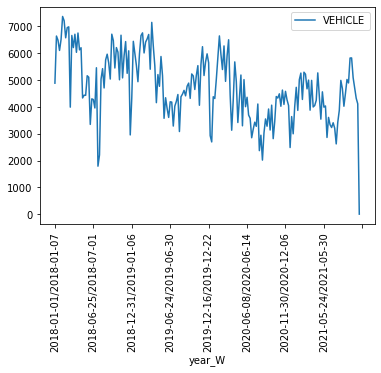

In [99]:
# Let's chart the bicycle volume by year

site_by_period.groupby('year_W')['VEHICLE'].median().reset_index().plot(x='year_W', y='VEHICLE',rot=90)

In [201]:
# correctly parse the datetime period
#df['year_week'] = pd.to_datetime(df['year_W'].str.split('/').str[0])
# get the week
df['week'] = df['year_W'].dt.to_period('W').dt.week
df['month'] = df['year_W'].dt.to_period('W').dt.month
df['year'] = df['year_W'].dt.strftime('%Y').astype(int)
df['year_M'] = df.apply(lambda x: f'{x["year"]}-{x["month"]}',axis=1)
df

,SITE_XN_ROUTE,LOC_LEG,year_W,VEHICLE,SPEED,HEADWAY,week,month,year,year_M
0,6411,59437,2018-01-01,4297,26.233512,138.659297,1,1,2018,2018-1
1,6411,59437,2018-01-08,6006,26.684898,99.384898,2,1,2018,2018-1
2,6411,59437,2018-01-15,6252,26.793154,94.771481,3,1,2018,2018-1
3,6411,59437,2018-01-22,6108,27.276735,97.878307,4,1,2018,2018-1
4,6411,59437,2018-01-29,6933,27.176662,86.131314,5,2,2018,2018-2
...,...,...,...,...,...,...,...,...,...,...
15795,40005,70011,2021-09-27,3641,22.010107,207.361631,39,10,2021,2021-10
15796,40005,70011,2021-10-04,3870,21.640827,183.929354,40,10,2021,2021-10
15797,40005,70011,2021-10-11,3417,22.067574,208.060433,41,10,2021,2021-10
15798,40005,70011,2021-10-18,3266,22.057226,268.532578,42,10,2021,2021-10


In [185]:
batlow10 = ['#011959',
'#103F60',
'#1C5A62',
'#3C6D56',
'#687B3E',
'#9D892B',
'#D29343',
'#F8A17B',
'#FDB7BC',
'#FACCFA']


In [191]:
df.query('(year==2021)&(week>44)')

,SITE_XN_ROUTE,LOC_LEG,year_W,VEHICLE,SPEED,HEADWAY,week,month,year,year_M
11853,6411,59437,2020-12-28,2823,24.901559,203.525434,53,1,2021,2021-1
11897,6411,59438,2020-12-28,2973,24.465859,198.322267,53,1,2021,2021-1
11941,6415,59485,2020-12-28,3059,19.565348,190.485453,53,1,2021,2021-1
11985,6415,59486,2020-12-28,3674,24.199265,158.264834,53,1,2021,2021-1
12029,6419,59458,2020-12-28,2508,14.006778,175.758054,53,1,2021,2021-1
...,...,...,...,...,...,...,...,...,...,...
15354,34314,63933,2020-12-28,1851,20.059968,331.337979,53,1,2021,2021-1
15398,34315,63934,2020-12-28,2469,18.672499,220.111786,53,1,2021,2021-1
15442,34315,63935,2020-12-28,2114,17.856670,259.911164,53,1,2021,2021-1
15486,34556,64397,2020-12-28,695,20.067338,749.633381,53,1,2021,2021-1


In [236]:
#df['m'] = df['month_year'].dt.strftime('%Y-%m')
df_volume = df.groupby(['year','week'])['VEHICLE'].sum().reset_index()

df_volume = df_volume.rename(columns={"VEHICLE":"Number of bicycles"})
df_volume['year_week'] = df_volume.apply(lambda x: f'{x["year"]}-{x["week"]}',axis=1)

# plotting for 2019, 2020, 2021, and 
# excluding terminal weeks (cause issues w/ year identification) and 
# incomplete sensor week in 2021
fig = px.line(df_volume.query('(year>2018)&(week>1)&(year_week!="2021-44")&(week<52)'), 
             x='week',
             y='Number of bicycles', 
             color='year',
             #height=800, width=800,
             markers = True,
             title="Bicycle Volume by week",
             color_discrete_sequence=[batlow10[8],batlow10[5],batlow10[0]],
              render_mode="SVG")

#fig.add_annotation(x= '1 Sep, 2020', y=60,
#           text="Text annotation with arrow",
#           showarrow=True,
#           arrowhead=1)

##fig.update_xaxes(
#    rangeslider_visible=True,
#    rangeselector=dict(
#        buttons=list([
#            dict(count=1, label="1m", step="month", stepmode="backward"),
#            dict(count=6, label="6m", step="month", stepmode="backward"),
#            dict(count=1, label="YTD", step="year", stepmode="todate"),
#            dict(count=1, label="1y", step="year", stepmode="backward"),
#            dict(step="all")
#        ])
#    )
#)
fig.update_traces(connectgaps=False)
# make space for explanation / annotation
fig.update_layout(margin=dict(l=20, r=20, t=40, b=60),paper_bgcolor="white")

# add annotation
fig.add_annotation(dict(font=dict(color='black',size=12),
                                        x=-0.05,
                                        y=-0.14,
                                        showarrow=False,
                                        text="Note: excludes weeks beginning and ending year, and incomplete week in November 2021",
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))
fig.show()
#fig.write_html('test.html')

In [53]:
#df['m'] = df['month_year'].dt.strftime('%Y-%m')
df_volume = df.query('(year>2017)&(year_M<"2021-11")')\
              .groupby(['year','week'])['VEHICLE'].sum().reset_index()

df_volume = df_volume.rename(columns={"VEHICLE":"Number of bicycles"})

fig = px.line(df_volume, 
             x='week',
             y='Number of bicycles', 
             color='year',
             #height=800, width=800,
             markers = True,
             title="Bicycle Volume by week",
             color_discrete_sequence=px.colors.sequential.Viridis,
              render_mode="SVG")

#fig.add_annotation(x= '1 Sep, 2020', y=60,
#           text="Text annotation with arrow",
#           showarrow=True,
#           arrowhead=1)

##fig.update_xaxes(
#    rangeslider_visible=True,
#    rangeselector=dict(
#        buttons=list([
#            dict(count=1, label="1m", step="month", stepmode="backward"),
#            dict(count=6, label="6m", step="month", stepmode="backward"),
#            dict(count=1, label="YTD", step="year", stepmode="todate"),
#            dict(count=1, label="1y", step="year", stepmode="backward"),
#            dict(step="all")
#        ])
#    )
#)
fig.show()
#fig.write_html('test.html')

<AxesSubplot:xlabel='year'>

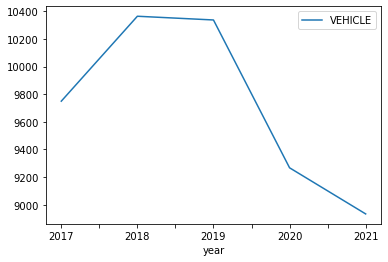

In [110]:
df.groupby('year')['VEHICLE'].median().reset_index().plot(x='year', y='VEHICLE')

In [93]:
# Here we'll map bicycle volume by year and create a slider or animation to show change

fig = px.scatter_mapbox(df_merge, lat="STRT_LAT", lon="STRT_LONG", hover_name="SITE_NAME",
                        hover_data=["SITE_ID", "BEARING_DESC", "VEHICLE", "SPEED", "HEADWAY"],
                        color = "VEHICLE",
                        size = "VEHICLE",
                        size_max=15,
                        color_continuous_scale = px.colors.sequential.haline_r,
                        opacity = 0.6,
                        range_color = [0, df_merge.VEHICLE.max()],
                        animation_frame = df_merge['month_year'].map(lambda x: x.strftime('%Y-%m')),
                        #size = [10]*len(df_merge),
                        zoom=10)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.layout.sliders[0].pad.t=6
fig.write_html(f'{visuals}Sensor_Map.html')
fig.show()

In [127]:
data_years

[2017, 2018, 2019, 2020, 2021]